This is an alternative version of the health clinic simulation, using a process oriented format.
This is a recovered copy.

This project will develop and explore a simple simulation of a health service provider, such as a clinic.

The following assumptions will be made:

Patients arrive at random intervals according to a Poisson process, the time between arrivals having an exponential distribution.

Patients will be randomly assigned a category of health condition.

Patients may have to wait for a doctor to be available to assess them.

When a doctor is available the patients are assessed and assigned to a specialist doctor/consultant according to the previously assigned condition. The number of doctors performing the initial assessment is a variable to be explored with the simulation.

Patients may have to wait for a specialist to be available.

When a specialist is available the patients are treated. The number of specialists for each category is a variable to be explored by the simulation.

It is assumed that no patients need emergency care so there is no need to prioritize them.

The clinic is open for 7 hours a day. Staff breaks will be ignored.

In [1]:
# import the required libraries
import simpy
import random
import pandas as pd
import statistics
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as st

The simulation will explore three primary performance indicators; total number of patients treated, mean patient waiting time and idle time for medical staff.

The number of patients that arrive but are not treated (or treatment is not completed) before the clinic closes will also be monitored.

Each simulation will be repeated N times and the mean result calculated for each performance indicator.

This first iteration of the simulation will explore how many times a simulation needs to be repeated to yield reliable results.

Also an exploration of a simple scenario involving the number of patients arriving but not receiving / completing treatment before the clinic closes.

In [2]:
# The outcomes for each simulation / run of simulations will be saved in lists.
total_patients_created = []
total_patients_treated = []
total_patients_untreated = []
    
# Patient numbers in each simulation will be saved in global variables
sim_patients_created = 0
sim_patients_treated = 0
    
# Mean patient waiting time and staff idle time in each simulation will be saved in a list
mean_waiting = []
idle_time = []
    
total_waiting_times = []
    
# Other outcomes of interest might include
# The maximum time any patient has to wait
    
# The simulation will be repeated N times
N = 1

The simulation will include:
4 Resources; the doctors conducting the initial assessment and three categories of specialists.

The associated parameters are:
The arrival rate of the patients.  
The distribution of the patient health conditions.  
The distribution of the time required for the initial assessment.  
The distribution of the time required for the specialist treatment of each condition.  

Parameters associated with the clinic are:  
The time that the clinic is open, measured in minutes.  
The time prior to the clinic closing that new patient arrivals are stopped.

In [3]:
# The parameters are:
RANDOM_SEED = 6

# The maximum number of patients arriving
MAX_NUM = 30 # replaced with stop time
    
# The mean time between patient arrivals (the unit of time used is minutes)
arrival_mean = 5
    
# The distribution of patient health conditions (probability, total sums to 1)
# Condition 0 will indicate the patient needs no further treatment
# cond_0_prob = 0.1
# cond_1_prob = 0.3
# cond_2_prob = 0.3
# cond_3_prob = 0.3
prob_dict = {0: 0.1, 1: 0.3, 2: 0.3, 3: 0.3}
    
# The mean time and standard deviation for a doctor to perform an initial assessment
# Assuming a normal distribution and discounting the minimal possibility of a negative time
assess_mean = 5
assess_sd = 1
    
# The mean time and standard deviation for a specialist to treat each health condition
# Assuming a normal distribution and discounting the minimal possibility of a negative time
special_1_mean = 15
special_1_sd = 3
    
special_2_mean = 15
special_2_sd = 3
    
special_3_mean = 15
special_3_sd = 3
    
# The time the clinic is open for / the simulation runs measured in minutes
clinic_time = 420
    
# New patients will stop being admitted some time prior to the clinic closing
stop_period = 20
# stop_time = clinic_time - stop_period

In [4]:
# The variables are:
    
# The number of doctors performing the initial assessments
num_doctors = 1
    
# The number of specialists treating the patients for each health condition
num_special_1 = 1
num_special_2 = 1
num_special_3 = 1

In [5]:
# Initialise the random number generator to allow results to be reproducible
random.seed(RANDOM_SEED)

In [6]:
# Create a function to randomly assign a condition to each patient
def assign_condition(prob_dict):
    rand_val = random.random()
    conditions = list(prob_dict.keys())
    probs = list(prob_dict.values())
    for i in range(len(conditions)):
        if rand_val <= sum(probs[0:i+1]):
            return conditions[i]
            break

In [7]:
# Create a function to generate patients
def source(env, max_num, arrival_mean, initial_assess, special_1, special_2, special_3,
              total_waiting_times, initial_assess_times, special_1_times, special_2_times, special_3_times):
    
    # create local variable to store number of patients created
    patients_created = 0
    
    # define sim_patients_created as the global variable   
    global sim_patients_created
        
    # generate patients while simulation time is less than stop_time
    while env.now < clinic_time - stop_period:
            
    # generate patients randomly upto the max_num
    # for i in range(max_num):
            
        # create new patient instance
        patients_created += 1
        sim_patients_created += 1
            
        # assign a condition to the patient
        condition = assign_condition(prob_dict)
        
        # pass patient to the patient process
        p = patient(env, 'patient {}'.format(patients_created), condition, initial_assess, special_1, special_2, special_3,
                        total_waiting_times, initial_assess_times, special_1_times, special_2_times, special_3_times)
        env.process(p)
            
        t = random.expovariate(1.0 / arrival_mean)
        yield env.timeout(t)

In [8]:
# Create a function to simulate a patient's journey through clinic
def patient(env, name, condition, initial_assess, special_1, special_2, special_3,
                total_waiting_times, initial_assess_times, special_1_times, special_2_times, special_3_times):
    
    # define sim_patients_treated as the global variable
    global sim_patients_treated
    
    # the patients total waiting time will be recorded
    patient_total_wait = 0
        
    # patient arrives
    arrive = env.now
    # print statements commented out to limit unnecessary output
    # print('{arrive} {name} has arrived'.format(arrive=arrive, name=name))
        
    with initial_assess.request() as req:
        yield req
                
        # patient has been assigned to a doctor for initial assessment
        initial_assess_start = env.now
        initial_wait = initial_assess_start - arrive
        # print statements commented out to limit unnecessary output
        # print('{time} {name} waited {wait} for initial assessment'.format(time=initial_assess_start, name=name, wait=initial_wait))
        patient_total_wait += initial_wait
            
        # the initial assessment takes place
        initial_assess_time = random.normalvariate(assess_mean, assess_sd)
        yield env.timeout(initial_assess_time)
        # record the initial assessment time
        initial_assess_times.append(initial_assess_time)
            
        # patient has finished initial asseement
        initial_assess_finish = env.now
        # print('{time} {name} finished initial assessment'.format(time=initial_assess_finish, name=name))
        
    # patient either requires specialist treatment or not
    if condition == 1:
        
        with special_1.request() as req:
            yield req
            
            # patient has been assigned to a doctor for specialist treatment
            special_1_start = env.now
            special_1_wait = special_1_start - initial_assess_finish
            # print('{time} {name} waited {wait} for specialist treatment 1'.format(time=special_1_start, name=name, wait=special_1_wait))
            patient_total_wait += special_1_wait
            
            # the specialist treatment takes place
            special_1_time = random.normalvariate(special_1_mean, special_1_sd)
            yield env.timeout(special_1_time)
            # record the special 1 treatment time
            special_1_times.append(special_1_time)
            
            # patient has finished specialist treatment
            special_1_finish = env.now
            # print('{time} {name} finished specialist treatment 1'.format(time=special_1_finish, name=name))
                
    elif condition == 2:
        
        with special_2.request() as req:
            yield req
            
            # patient has been assigned to a doctor for specialist treatment
            special_2_start = env.now
            special_2_wait = special_2_start - initial_assess_finish
            # print('{time} {name} waited {wait} for specialist treatment 2'.format(time=special_2_start, name=name, wait=special_2_wait))
            patient_total_wait += special_2_wait
            
            # the specialist treatment takes place
            special_2_time = random.normalvariate(special_2_mean, special_2_sd)
            yield env.timeout(special_2_time)
            # record the special 2 treatment time
            special_2_times.append(special_2_time)
            
            # patient has finished specialist treatment
            special_2_finish = env.now
            # print('{time} {name} finished specialist treatment 2'.format(time=special_2_finish, name=name))
        
    elif condition == 3:
        
        with special_3.request() as req:
            yield req
            
            # patient has been assigned to a doctor for specialist treatment
            special_3_start = env.now
            special_3_wait = special_3_start - initial_assess_finish
            # print('{time} {name} waited {wait} for specialist treatment 3'.format(time=special_3_start, name=name, wait=special_3_wait))
            patient_total_wait += special_3_wait
            
            # the specialist treatment takes place
            special_3_time = random.normalvariate(special_3_mean, special_3_sd)
            yield env.timeout(special_3_time)
            # record the special 3 treatment time
            special_3_times.append(special_3_time)
            
            # patient has finished specialist treatment
            special_3_finish = env.now
            # print('{time} {name} finished specialist treatment 3'.format(time=special_3_finish, name=name))
    
    else:
        pass
        # print('{time} {name} does not require specialist treatment'.format(time=initial_assess_finish, name=name))
        
    # the patient's total waiting time is added to a list
    total_waiting_times.append(patient_total_wait)
        
    # the number of patients treated (or not requiring treatment is recorded)
    sim_patients_treated += 1

In [9]:
# Create a function to perform a simulation N times
    
def run_simulation(N):
    # confirm global variables
    global sim_patients_created
    global sim_patients_treated
        
    # create lists to store results / remove values from previous runs
    total_patients_created = []
    total_patients_treated = []
    total_patients_untreated = []
    mean_waiting = []
    idle_time = []
        
    for i in range(N):
        # print statements commented out to limit unnecessary output
        # print('Start Simulation {}'.format(i))
        
        # reset variables to count number of patients created and treated
        sim_patients_created = 0
        sim_patients_treated = 0
        
        # create list to store simulation waiting times
        total_waiting_times = []
        
        # create lists to store simulation initial assessment times and treatment times
        initial_assess_times = []
        special_1_times = []
        special_2_times = []
        special_3_times = []
        
        # set up the simulation
        env = simpy.Environment()
        
        # start processes and run
        initial_assess = simpy.Resource(env, capacity=num_doctors)
        special_1 = simpy.Resource(env, capacity=num_special_1)
        special_2 = simpy.Resource(env, capacity=num_special_2)
        special_3 = simpy.Resource(env, capacity=num_special_3)
        env.process(source(env, MAX_NUM, arrival_mean, initial_assess, special_1, special_2, special_3,
                                total_waiting_times, initial_assess_times, special_1_times, special_2_times, special_3_times))
        env.run(until=clinic_time)
        
        # save mean waiting time to list
        mean_waiting.append(round(statistics.mean(total_waiting_times), 2))
        
        # save idle time to list
        total_staff_time = (num_doctors + num_special_1 + num_special_2 + num_special_3) * clinic_time
        total_work_time = sum(initial_assess_times + special_1_times + special_2_times + special_3_times)
        idle_time.append(round(total_staff_time - total_work_time, 2))
        
        # save number of patients created to list
        total_patients_created.append(sim_patients_created)
        
        # save number of patients treated to list
        total_patients_treated.append(sim_patients_treated)
        
        # save number of patients untreated at end of simulation to list
        total_patients_untreated.append(sim_patients_created - sim_patients_treated)
        
    # create results dataframe
    sim_run_df = pd.DataFrame(list(zip(total_patients_created, total_patients_treated, total_patients_untreated, 
                                       mean_waiting, idle_time)),
                                 columns=['Patients Created', 'Patients Treated', 'Patients Untreated', 
                                          'Mean Waiting Time', 'Idle Time'])
        
    return sim_run_df

In [10]:
# Create a function to draw plots
    
def draw_sim_plots(sim_df, xlabel):
    plt.figure(figsize=(16, 12))
    plt.subplot(2, 2, 1)
    plt.bar(sim_df.index, sim_df['Patients Created'], alpha=0.5)
    plt.bar(sim_df.index, sim_df['Patients Treated'])
    plt.xlabel(xlabel)
    plt.ylabel('Patients')
    plt.title('Patients Created / Treated')
    plt.xticks(sim_df.index, sim_df.index)
    
    plt.subplot(2, 2, 2)
    plt.bar(sim_df.index, sim_df['Patients Untreated'])
    plt.xlabel(xlabel)
    plt.ylabel('Patients')
    plt.title('Patients Untreated')
    plt.xticks(sim_df.index, sim_df.index)
    
    plt.subplot(2, 2, 3)
    plt.bar(sim_df.index, sim_df['Mean Waiting Time'])
    plt.xlabel(xlabel)
    plt.ylabel('Time (minutes)')
    plt.title('Mean Waiting Time')
    plt.xticks(sim_df.index, sim_df.index)
    
    plt.subplot(2, 2, 4)
    plt.bar(sim_df.index, sim_df['Idle Time'])
    plt.xlabel(xlabel)
    plt.ylabel('Time (minutes)')
    plt.title('Staff Idle Time')
    plt.xticks(sim_df.index, sim_df.index)
    
    plt.show()

To investigate the simulation I will begin with a simple setup:
Patients arrive at mean 5 minute intervals.
Patients have equal probability of having each of 3 conditions (there is a 10% chance of not needing treatment).
Initial assessment takes a mean of 5 minutes.
Specialist treatment takes a mean of 15 minutes.
There is one doctor conducting the initial assessments.
There is one specialist for each condition.

Disregarding random variation this setup has a balance between patient arrivals and the resources (doctors / specialists).

In [11]:
# Run the simulation 20 times.
sim_20_01 = run_simulation(20)

sim_20_01

,Patients Created,Patients Treated,Patients Untreated,Mean Waiting Time,Idle Time
0,62,57,5,17.60,575.77
1,88,74,14,44.68,261.92
2,86,76,10,38.97,286.31
3,82,72,10,42.74,285.10
4,80,74,6,25.68,328.20
5,75,67,8,30.64,385.07
6,81,77,4,42.93,264.90
7,76,68,8,32.73,382.29
8,79,73,6,36.29,272.38
9,87,77,10,46.84,224.12


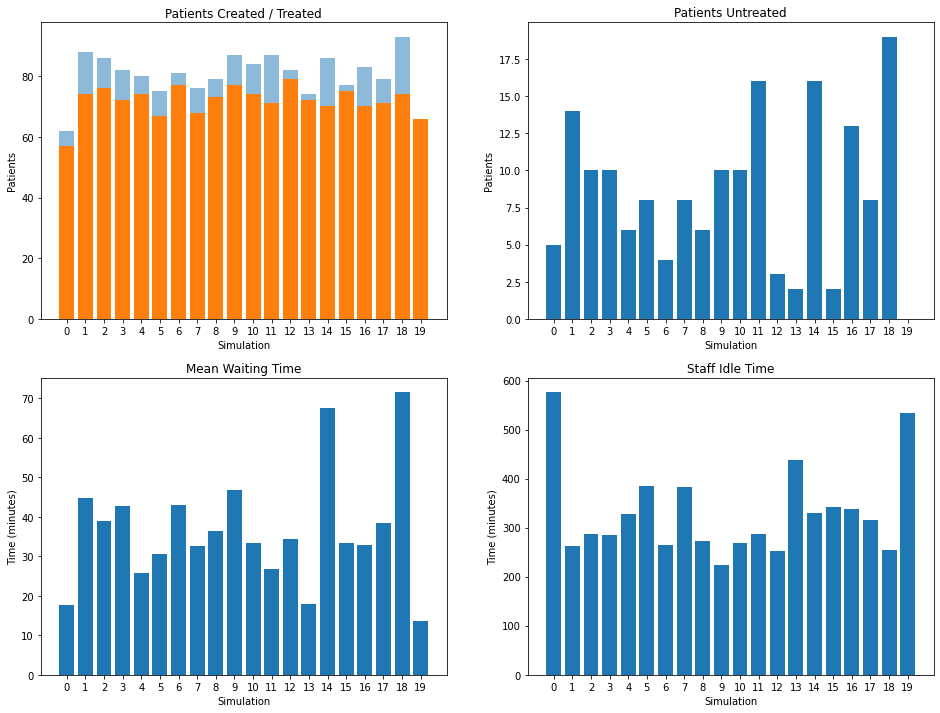

In [12]:
# plot results
draw_sim_plots(sim_20_01, 'Simulation')

In [13]:
# calculate the mean values for the simulations
sim_20_01.mean()

Patients Created       80.350
Patients Treated       71.850
Patients Untreated      8.500
Mean Waiting Time      36.455
Idle Time             331.244
dtype: float64

In [14]:
# calculate the standard deviation for the simulations
sim_20_01.std()

Patients Created       7.407500
Patients Treated       4.880412
Patients Untreated     5.206272
Mean Waiting Time     14.468141
Idle Time             93.057989
dtype: float64

From the plots we can see there is considerable variation in results between simulations.

With an arrival rate of 1/5 and a patient arriving at 0.0 we would expect 81 patients to arrive in 400 minutes (420 - 20 stop time). The mean is 80.350. The maximum observed was 93 and the minimum 62.

There is less variation in the numbers of Patients Treated.

Compared to the mean value there is considerably more variation in the number of Patients Untreated, a mean of 8.5 with a standard deviation of 5.2.

Relative to their mean values, Mean Waiting Time and Idle Time have similar standard deviations.

In [15]:
# Repeat running the simulation 20 times to check if results are consistant
sim_20_02 = run_simulation(20)
sim_20_03 = run_simulation(20)
sim_20_04 = run_simulation(20)
sim_20_05 = run_simulation(20)

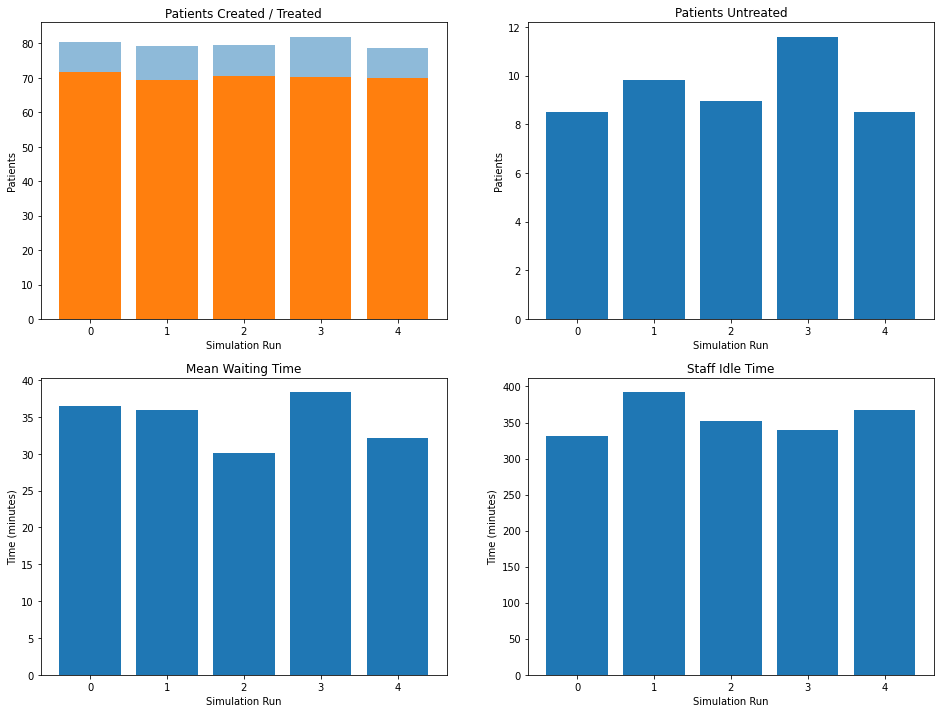

In [16]:
# Plot the results for the different simulation runs
data = [list(sim_20_01.mean()), list(sim_20_02.mean()), list(sim_20_03.mean()), 
        list(sim_20_04.mean()), list(sim_20_05.mean())]
    
result_df = pd.DataFrame(data, columns=sim_20_01.columns)
    
draw_sim_plots(result_df, 'Simulation Run')

In [17]:
# Review the mean values for each 20 run simulation
result_df

,Patients Created,Patients Treated,Patients Untreated,Mean Waiting Time,Idle Time
0,80.35,71.85,8.50,36.4550,331.244
1,79.20,69.40,9.80,35.9915,391.761
2,79.60,70.65,8.95,30.1100,352.272
3,82.00,70.40,11.60,38.3310,339.529
4,78.55,70.05,8.50,32.1020,367.821


In [18]:
# Review the standard deviations of the mean values
result_df.std()

Patients Created       1.323537
Patients Treated       0.903189
Patients Untreated     1.303649
Mean Waiting Time      3.380005
Idle Time             24.058555
dtype: float64

From the results of running the simulation 20 times repeatedly we see that there is some variation of mean outcomes.

As noted after the first simulation run the most variance is observed in the Patients Untreated, Mean Waiting Time and Idle Time.

In [19]:
# Try running the simulation 50 times
sim_50_01 = run_simulation(50)
sim_50_02 = run_simulation(50)
sim_50_03 = run_simulation(50)
sim_50_04 = run_simulation(50)
sim_50_05 = run_simulation(50)

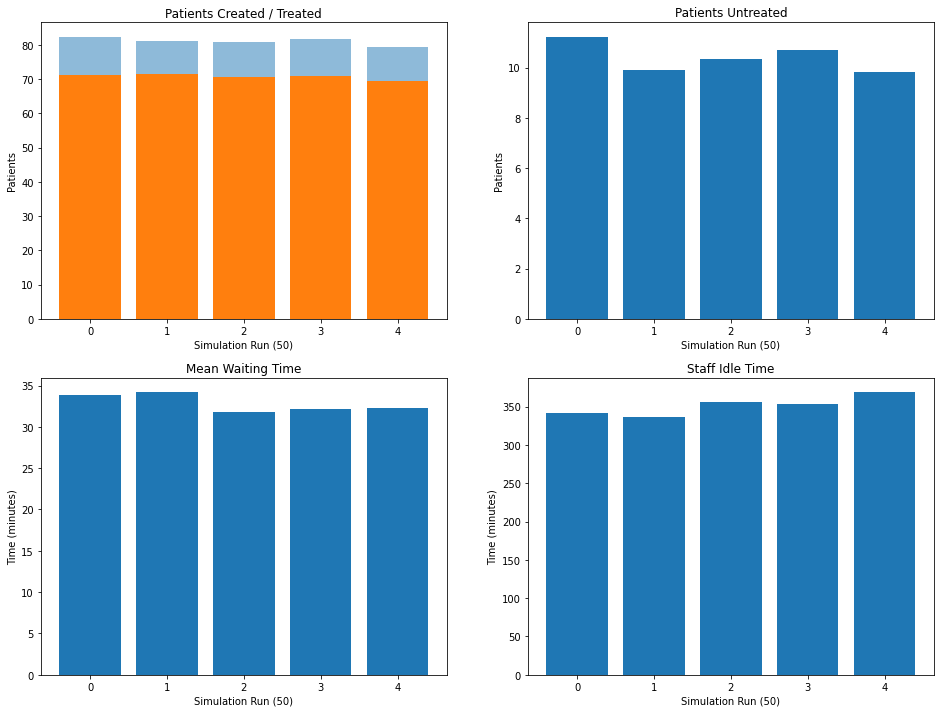

In [20]:
# Plot the results for the different simulation runs
data = [list(sim_50_01.mean()), list(sim_50_02.mean()), list(sim_50_03.mean()), 
        list(sim_50_04.mean()), list(sim_50_05.mean())]
    
result_50_df = pd.DataFrame(data, columns=sim_50_01.columns)
    
draw_sim_plots(result_50_df, 'Simulation Run (50)')

In [21]:
result_50_df

,Patients Created,Patients Treated,Patients Untreated,Mean Waiting Time,Idle Time
0,82.42,71.18,11.24,33.9036,342.0456
1,81.26,71.36,9.90,34.1646,336.2272
2,80.86,70.50,10.36,31.7598,355.2836
3,81.72,71.02,10.70,32.1358,352.7606
4,79.24,69.40,9.84,32.3352,368.4200


In [22]:
result_50_df.mean()

Patients Created       81.1000
Patients Treated       70.6920
Patients Untreated     10.4080
Mean Waiting Time      32.8598
Idle Time             350.9474
dtype: float64

In [23]:
result_50_df.std()

Patients Created       1.190546
Patients Treated       0.790266
Patients Untreated     0.583198
Mean Waiting Time      1.095605
Idle Time             12.483073
dtype: float64

In [24]:
# Try running the simulation 100 times
sim_100_01 = run_simulation(100)
sim_100_02 = run_simulation(100)
sim_100_03 = run_simulation(100)
sim_100_04 = run_simulation(100)
sim_100_05 = run_simulation(100)

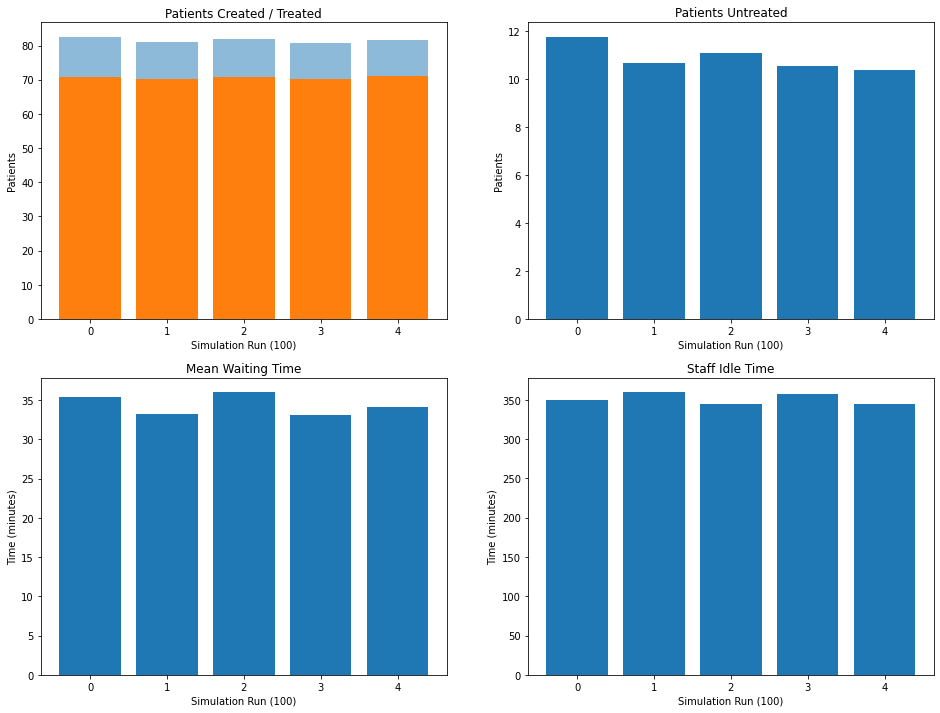

In [25]:
# Plot the results for the different simulation runs
data = [list(sim_100_01.mean()), list(sim_100_02.mean()), list(sim_100_03.mean()), 
        list(sim_100_04.mean()), list(sim_100_05.mean())]
    
result_100_df = pd.DataFrame(data, columns=sim_100_01.columns)
    
draw_sim_plots(result_100_df, 'Simulation Run (100)')

In [26]:
result_100_df

,Patients Created,Patients Treated,Patients Untreated,Mean Waiting Time,Idle Time
0,82.62,70.84,11.78,35.3953,349.9325
1,80.94,70.25,10.69,33.2927,359.5820
2,81.93,70.82,11.11,35.9836,344.8677
3,80.79,70.23,10.56,33.0810,357.5391
4,81.50,71.10,10.40,34.0747,344.2388


In [27]:
result_100_df.mean()

Patients Created       81.55600
Patients Treated       70.64800
Patients Untreated     10.90800
Mean Waiting Time      34.36546
Idle Time             351.23202
dtype: float64

In [28]:
result_100_df.std()

Patients Created      0.748552
Patients Treated      0.388549
Patients Untreated    0.554049
Mean Waiting Time     1.281029
Idle Time             7.081664
dtype: float64

Running the simulation first 50 times and then 100 times we see a substantial reduction in variation of the mean outcomes at 50 and a slight further reduction at 100. The most variance relatively is still observed in the Patients Untreated outcome, which also showed the least reduction in variance between running the simulation 50 and 100 times.

To investigate the reliability of the results further we can calculate confidence intervals for the population means from a large sample of simulation runs. With a large sample we can assume a normal distribution.

In [29]:
# Calculate a confidence interval using a large sample (250 simulation runs)

# Run the simulation 250 times
sim_250 = run_simulation(250)

# Calculate the mean values for the large dataset
sim_250.mean()

Patients Created       80.36400
Patients Treated       69.82400
Patients Untreated     10.54000
Mean Waiting Time      32.33960
Idle Time             367.06776
dtype: float64

In [30]:
# Calculate the standard deviation for the large dataset
sim_250.std()

Patients Created       9.021589
Patients Treated       4.644060
Patients Untreated     6.640541
Mean Waiting Time     14.461843
Idle Time             95.104823
dtype: float64

In [31]:
# Calculate 95% confidence intervals for the large dataset
Patients_Untreated_CI = st.norm.interval(alpha=0.95, loc=sim_250['Patients Untreated'].mean(), 
                                    scale=st.sem(sim_250['Patients Untreated']))

Mean_Waiting_CI = st.norm.interval(alpha=0.95, loc=sim_250['Mean Waiting Time'].mean(),
                                  scale=st.sem(sim_250['Mean Waiting Time']))

Idle_Time_CI = st.norm.interval(alpha=0.95, loc=sim_250['Idle Time'].mean(),
                               scale=st.sem(sim_250['Idle Time']))

print('Large dataset - Patients Untreated Confidence Interval: ', Patients_Untreated_CI)
print('Large dataset - Mean Waiting Time Confidence Interval: ', Mean_Waiting_CI)
print('Large dataset - Idle Time Confidence Interval: ', Idle_Time_CI)

Large dataset - Patients Untreated Confidence Interval:  (9.716845113101455, 11.363154886898544)
Large dataset - Mean Waiting Time Confidence Interval:  (30.546924294226176, 34.132275705773814)
Large dataset - Idle Time Confidence Interval:  (355.2786606578753, 378.8568593421247)


Given this sample of 250 simulations we have plausible ranges for the population means of:
Patients Untreated: (9.72, 11.36)
Mean Waiting Time: (30.55, 34.13)
Idle Time: (355.28, 378.86)

Comparing the confidence intervals to the results from the 100 runs we see that there are some noticeable differences.

Four of the five observed Patients Untreated means are within the confidence interval. The highest mean Patients Untreated observed in the 100 runs was 11.78, which is outside the confidence interval by approximately 0.4. The confidence interval lower bound is 0.7 below the lowest observed mean.

Three of the five observed Mean Waiting Time means are within the confidence interval. The remaining two are greater than the upper bound of the confidence interval (the highest is 35.98). The lower bound of the confidence interval is 2.5 below than the lowest observed mean.

Only two of the five observed Idle Time means are within the confidence interval. The remaining three are all below the lower bound of the confidence interval. The lowest observed value is 344.2. The highest observed value was 359.6 which is approximately 29 lower than the upper bound of the confidence interval and only 4 above the lower bound.

From these results we can infer there is still significant variation in the results of the 100 simulation runs. The Patients Untreated mean from sim_100_01 appears to be unusually high.

It is also possible that 250 simulation runs are not enough to ensure the results are not affected by unusual results. The Mean Waiting Time mean from the 250 runs is 32.34 which is lower than all five 100 run results. That accounts for why two 100 run values are above the confidence interval upper bound. The Idle Time is negatively correlated with the Mean Waiting Time so that also explains why the 100 run values are generally low in comparison to the confidence interval.

To have confidence in the usefulness of the results for a particular application we can calculate an approximate sample size required.
We can assume the sample means are normally distributed due to the Central Limit Theorem.
The parameters used to determine the sample size are:
    the standard deviation of the population which will be estimated using a sample standard deviation (std_dev),
    the maximum desired error of estimation (bound),
    the probability that the error of estimation will be less than the maximum desired (prob).

In [32]:
# Create a function to calculate a sample size n
def calculate_n(std_dev, bound, prob):
    alpha = 1 - prob
    z = st.norm.ppf(1-(alpha/2))
    n = (z / bound)**2 * std_dev**2
    return print('The required sample size is approximately: ', round(n, 0))

We can test whether 100 simulation runs are appropriate in a variety of situations.
We will use the standard deviations of the 250 run sample to estimate the population standard deviations.

First, suppose we want to investigate the Mean Waiting Time and want the results to be within 3 minutes of the population mean with 0.95 probability. 

In [33]:
# Calculate the required sample size for Mean Waiting Time with bound = 3, and probability = 0.95.
calculate_n(14.46, 3, 0.95)

The required sample size is approximately:  89.0


Next, suppose we want to investigate the Patients Untreated and want the results to be within 0.5 of the population mean with 0.9 probability.

In [34]:
# Calculate the required sample size for Patients Untreated with bound = 0.5, and probability = 0.9.
calculate_n(6.64, 0.5, 0.95)

The required sample size is approximately:  677.0


Increasing the bound to 1 and decreasing the the probability of the sample mean being within the bound of the population mean will reduce the sample size required. 

In [35]:
# Calculate the required sample size for Patients Untreated with bound = 1.0 and probability = 0.9.
calculate_n(6.64, 1, 0.9)

The required sample size is approximately:  119.0


Finally, suppose we want to investigate the Idle Time and want the results to be within 30 minutes of the population mean with 0.99 probability. 

In [36]:
# Calculate the required sample size for Idle Time with bound = 30 and probability = 0.99.
calculate_n(95.10, 30, 0.99)

The required sample size is approximately:  67.0


Hence we can be reasonably confident that the 100 simulation runs will produce useful estimates of the population means provided a high degree of accuracy is not required. Estimating the Patients Untreated is perhaps the most problematic since the standard deviation is relatively high compared to the mean value.

In the above simulation runs we observed mean values for Patients Untreated between 10.40 and 11.78. Ideally no patients would need to be turned away without receiving treatment after waiting for some time. So a parameter of interest is the stop time for new patient arrivals.

Suppose the clinic manager determined that they should aim for less than 1 patient turned away without treatment on average. To achieve that the manager decides to change the stop time for new arrivals. Hence the target for Patients Untreated is < 1 and stop_period will be changed. All other parameters and variables will remain unchanged.

The default value used in the above simulation runs was 20 minutes (before the clinic closed).
Intuitively with patients arriving at a mean rate of 1/5 it is likely to require the stop time to be increased by 50 minutes to reduce the Patients Untreated to less than 1 from approximately 11.

Initially I will try stop_period values 20, 40, 60, 80, 100, 120 minutes.

To calculate the approximate sample size required I will assume we want the results to be within 0.75 of the population mean with probability 0.9. I will use the standard deviation of the 250 run sample as an estimate of the population mean.

In [38]:
# Calculate the required sample size for Patients Untreated with bound = 0.75 and probability = 0.9.
calculate_n(6.64, 0.75, 0.9)

The required sample size is approximately:  212.0


Hence we will use a sample size of 215.

In [39]:
# Repeat simulation runs with different stop times
stop_period = 20
sim_st20 = run_simulation(215)

stop_period = 40
sim_st40 = run_simulation(215)

stop_period = 60
sim_st60 = run_simulation(215)

stop_period = 80
sim_st80 = run_simulation(215)

stop_period = 100
sim_st100 = run_simulation(215)

stop_period = 120
sim_st120 = run_simulation(215)

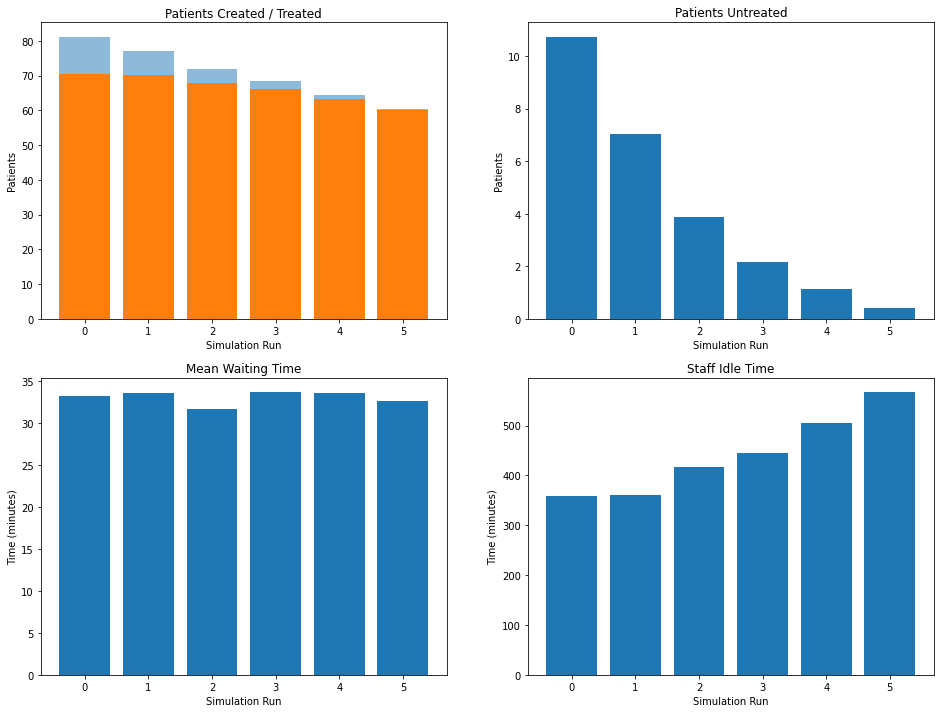

In [40]:
# Plot the results for the different simulation runs
data = [list(sim_st20.mean()), list(sim_st40.mean()), list(sim_st60.mean()), 
        list(sim_st80.mean()), list(sim_st100.mean()), list(sim_st120.mean())]
    
result_st_df = pd.DataFrame(data, columns=sim_st20.columns)
    
draw_sim_plots(result_st_df, 'Simulation Run')

In [41]:
result_st_df

,Patients Created,Patients Treated,Patients Untreated,Mean Waiting Time,Idle Time
0,81.246512,70.506977,10.739535,33.183721,358.027209
1,77.093023,70.074419,7.018605,33.617349,360.434372
2,71.911628,68.018605,3.893023,31.658047,417.299488
3,68.358140,66.181395,2.176744,33.652605,445.540140
4,64.474419,63.339535,1.134884,33.626977,505.939907
5,60.418605,60.004651,0.413953,32.688465,566.751767


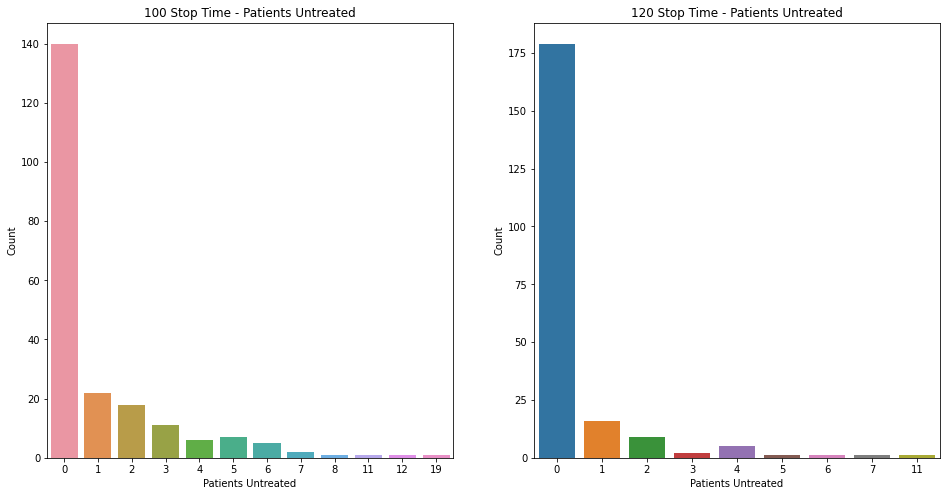

In [42]:
# Plot barcharts of the sim_st100 and sim_st120 Patients Untreated results
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.countplot(data=sim_st100, x='Patients Untreated')
plt.xlabel('Patients Untreated')
plt.ylabel('Count')
plt.title('100 Stop Time - Patients Untreated')
    
plt.subplot(1, 2, 2)
sns.countplot(data=sim_st120, x='Patients Untreated')
plt.xlabel('Patients Untreated')
plt.ylabel('Count')
plt.title('120 Stop Time - Patients Untreated')

plt.show()

We can see that a stop period of 120 minutes, closing the clinic to new arrivals at 420 - 120 minutes, appears to be the best solution to reduce the mean number of Untreated Patients to below 1.

The mean number of Patients Treated has been reduced by approximately 10 and the number of Untreated Patients has been reduced by approximately 10. The Mean Waiting Time has remained in the range previously seen. The Idle Time has increased substantially.

As the mean Patients Untreated is reduced it is expected that the standard deviation of the variable will also reduce since there is a minimum possible value of 0. Hence it is possible that the sample size could have been reduced for the simulations with higher Stop Time values.

In [43]:
sim_st120.std()

Patients Created        7.753301
Patients Treated        7.177651
Patients Untreated      1.268154
Mean Waiting Time      14.256158
Idle Time             136.726994
dtype: float64

In [44]:
sim_st100.std()

Patients Created        8.411610
Patients Treated        7.163059
Patients Untreated      2.323276
Mean Waiting Time      15.558339
Idle Time             140.866044
dtype: float64

In [45]:
# For the standard deviation of the sim_st120 sample
# Calculate the required sample size for Patients Untreated with bound = 0.5 and probability = 0.9 
calculate_n(1.27, 0.5, 0.9)

The required sample size is approximately:  17.0


In [46]:
# For the standard deviation of the sim_st100 sample
# Calculate the required sample size for Patients Untreated with bound = 0.5 and probability = 0.9
calculate_n(2.32, 0.5, 0.9)

The required sample size is approximately:  58.0


In [47]:
# Refine the Stop Time using smaller increments.
# We can reduce the sample size to 100 while retaining at least the desired level of accuracy.
stop_period = 100
sim2_st100 = run_simulation(100)

stop_period = 105
sim2_st105 = run_simulation(100)

stop_period = 110
sim2_st110 = run_simulation(100)

stop_period = 115
sim2_st115 = run_simulation(100)

stop_period = 120
sim2_st120 = run_simulation(100)

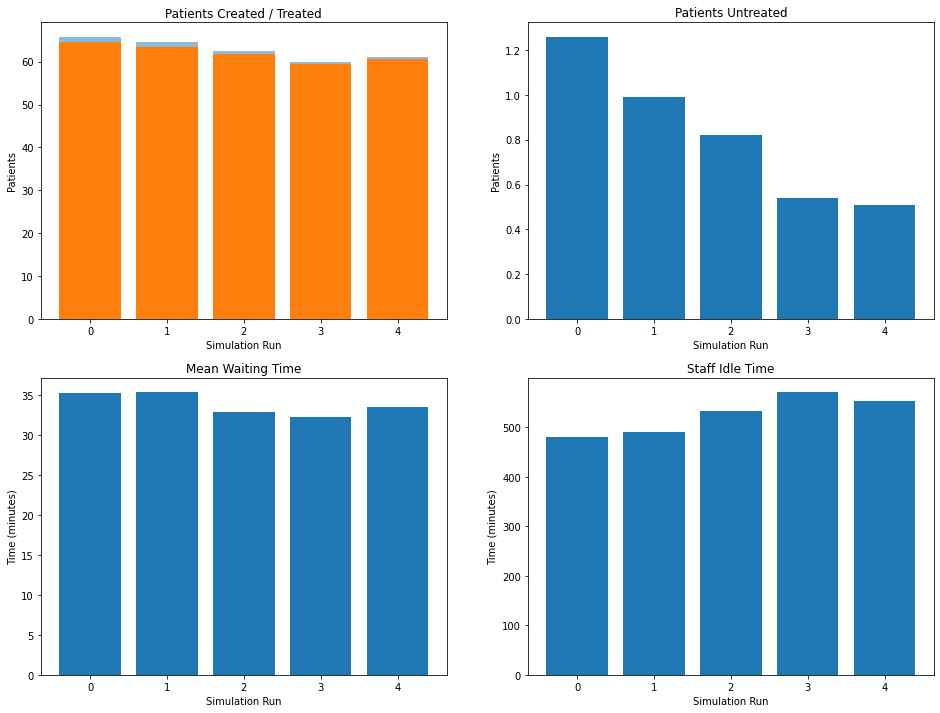

In [48]:
# Plot the results for the different simulation runs
data2 = [list(sim2_st100.mean()), list(sim2_st105.mean()), list(sim2_st110.mean()), 
        list(sim2_st115.mean()), list(sim2_st120.mean())]
    
result2_st_df = pd.DataFrame(data2, columns=sim2_st100.columns)
    
draw_sim_plots(result2_st_df, 'Simulation Run')

In [49]:
result2_st_df

,Patients Created,Patients Treated,Patients Untreated,Mean Waiting Time,Idle Time
0,65.83,64.57,1.26,35.2652,479.7722
1,64.49,63.50,0.99,35.3412,491.5325
2,62.51,61.69,0.82,32.8753,533.8216
3,59.99,59.45,0.54,32.2543,570.8334
4,61.13,60.62,0.51,33.4753,553.7584


Based on these results we could adjust the stop period to 110, closing the clinic at 420 - 110, and still be reasonably confident that on average Patients Untreated will be less than one. 